In [1]:
! pip install statsforecast s3fs datasetsforecast

! pip install git+https://github.com/Nixtla/neuralforecast.git@main


  Cloning https://github.com/Nixtla/neuralforecast.git (to revision main) to /private/var/folders/v0/84lzkbf93gq9sjdc9ccj38p00000gq/T/pip-req-build-ygxmp4oj
  Running command git clone --filter=blob:none --quiet https://github.com/Nixtla/neuralforecast.git /private/var/folders/v0/84lzkbf93gq9sjdc9ccj38p00000gq/T/pip-req-build-ygxmp4oj
  Resolved https://github.com/Nixtla/neuralforecast.git to commit 0b4332ce1181f020c7132a86603f3cbf2b22dac5
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import pandas as pd

Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')

Y_df.head()


,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


In [3]:
Y_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373372 entries, 0 to 373371
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   unique_id  373372 non-null  object 
 1   ds         373372 non-null  int64  
 2   y          373372 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.5+ MB


In [4]:
uids = Y_df['unique_id'].unique()[:10] # Select 10 ids to make the example faster
Y_df = Y_df.query('unique_id in @uids').reset_index(drop=True)


/Users/leandro.cardozo/pess/Pós/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


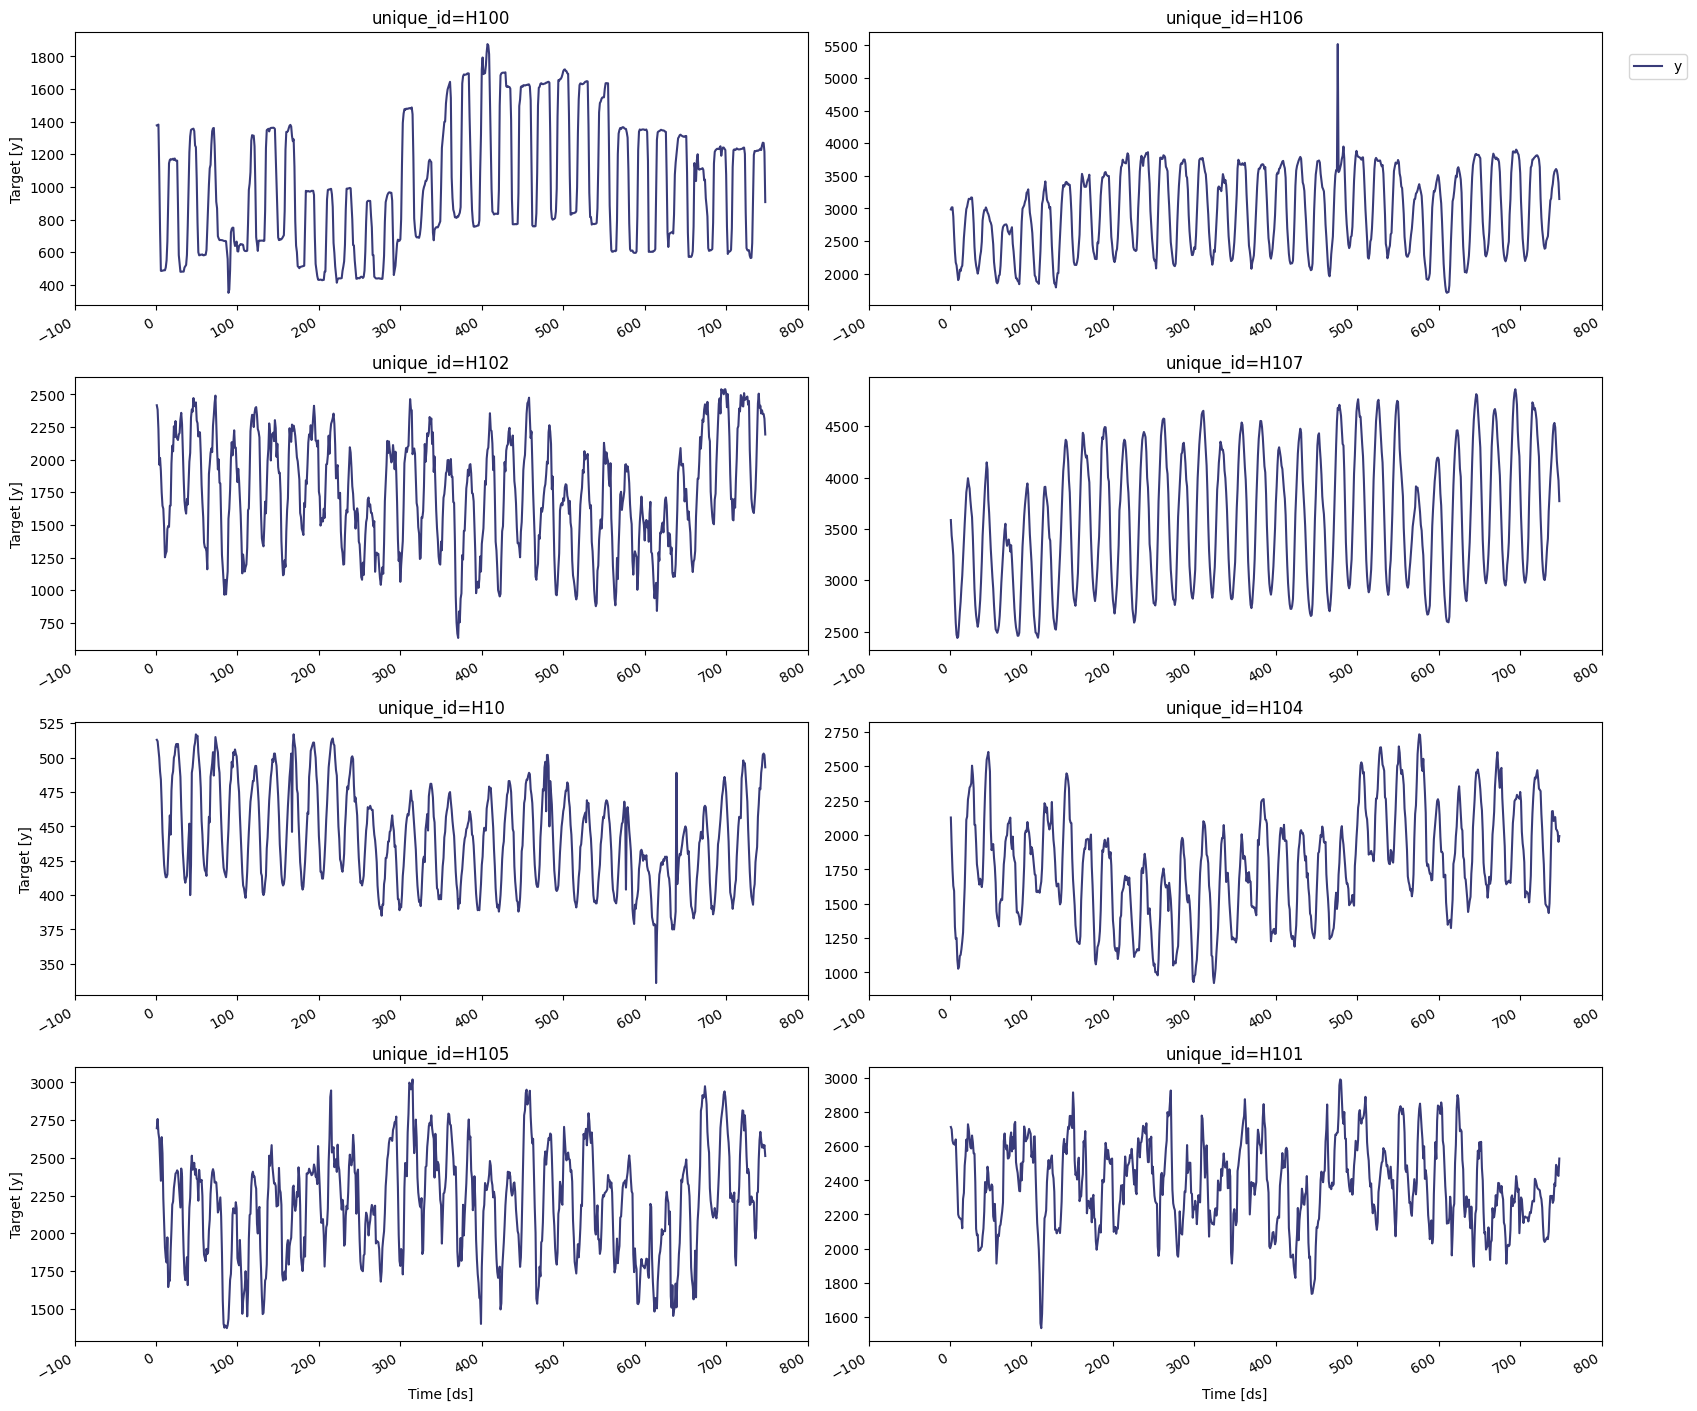

In [5]:
from statsforecast import StatsForecast

StatsForecast.plot(Y_df, engine='matplotlib')



In [6]:
from ray import tune

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MQLoss


2024-07-24 20:03:58,550	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-07-24 20:03:58,707	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [7]:
config_nhits = {
    "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
    "start_padding_enabled": True,
    "n_blocks": 5*[1],                                              # Length of input window
    "mlp_units": 5 * [[64, 64]],                                  # Length of input window
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],         
                                      [8, 4, 2, 1, 1]]),            # MaxPooling Kernel size
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
                                      [1, 1, 1, 1, 1]]),            # Interpolation expressivity ratios
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   # Initial Learning rate
    "scaler_type": tune.choice([None]),                             # Scaler type
    "max_steps": tune.choice([1000]),                               # Max number of training iterations
    "batch_size": tune.choice([1, 4, 10]),                          # Number of series in batch
    "windows_batch_size": tune.choice([128, 256, 512]),             # Number of windows in batch
    "random_seed": tune.randint(1, 20),                             # Random seed
}

config_lstm = {
    "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
    "encoder_hidden_size": tune.choice([64, 128]),            # Hidden size of LSTM cells
    "encoder_n_layers": tune.choice([2,4]),                   # Number of layers in LSTM
    "learning_rate": tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
    "scaler_type": tune.choice(['robust']),                   # Scaler type
    "max_steps": tune.choice([500, 1000]),                    # Max number of training iterations
    "batch_size": tune.choice([1, 4]),                        # Number of series in batch
    "random_seed": tune.randint(1, 20),                       # Random seed
}


In [8]:
models=[
        AutoNHITS(h=48, config=config_nhits, loss=MQLoss(), num_samples=5),
        AutoLSTM(h=48, config=config_lstm, loss=MQLoss(), num_samples=2),
    ]
nf = NeuralForecast(
    models=models, freq=1
)


In [9]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [10]:
nf.fit(df=Y_df)


(_train_tune pid=56968) /Users/leandro.cardozo/pess/Pós/.venv/lib/python3.12/site-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=56968) Seed set to 19
(_train_tune pid=56968) GPU available: True (mps), used: True
(_train_tune pid=56968) TPU available: False, using: 0 TPU cores
(_train_tune pid=56968) HPU available: False, using: 0 HPUs
(_train_tune pid=56968) Missing logger folder: /private/tmp/ray/session_2024-07-24_20-04-00_850740_56516/artifacts/2024-07-24_20-07-44/_train_tune_2024-07-24_20-07-44/working_dirs/_train_tune_03a3a_00000_0_batch_size=4,encoder_hidden_size=128,encoder_n_layers=4,input_size=96,learning_rate=0.0002,max_steps=100_2024-07-24_20-07-44/lightning_logs
(_train_tune pid=56968) 
(_train_tune pid=56968)   | Name            | Type          | Params | Mode 
(_train_tune pid=56968) -----

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(_train_tune pid=56968) /Users/leandro.cardozo/pess/Pós/.venv/lib/python3.12/site-packages/neuralforecast/common/_scalers.py:30: UserWarning: The operator 'aten::nanmedian.dim_values' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
(_train_tune pid=56968)   x_median, _ = x_nan.nanmedian(dim=dim, keepdim=keepdim)


Epoch 33:  33%|███▎      | 1/3 [00:00<00:00, 29.11it/s, v_num=0, train_loss_step=0.249, train_loss_epoch=0.248]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 10.17it/s]
(_train_tune pid=56968) 
Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00, 11.96it/s]
(_train_tune pid=56968) 
Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]
(_train_tune pid=56968) 
Epoch 66:  67%|██████▋   | 2/3 [00:00<00:00, 26.48it/s, v_num=0, train_loss_step=0.246, train_loss_epoch=0.230, valid_loss=340.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]
(_train_tune pid=56968) 
Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 12.16it/s]
(_train_tune pid=56968) 
Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 14.58it/s]
(_train_tune pid=56968) 
Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 31.94it/s, v_num=0, train_loss_step=0.210, train_loss

(_train_tune pid=56968) `Trainer.fit` stopped: `max_steps=1000` reached.
(_train_tune pid=56968) /opt/homebrew/Cellar/python@3.12/3.12.4/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_train_tune pid=56968)   warnings.warn('resource_tracker: There appear to be %d '


(_train_tune pid=56968) 
Epoch 333:  33%|███▎      | 1/3 [00:00<00:00,  3.49it/s, v_num=0, train_loss_step=0.226, train_loss_epoch=0.226, valid_loss=324.0]


(_train_tune pid=57014) /Users/leandro.cardozo/pess/Pós/.venv/lib/python3.12/site-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=57014) Seed set to 8
(_train_tune pid=57014) GPU available: True (mps), used: True
(_train_tune pid=57014) TPU available: False, using: 0 TPU cores
(_train_tune pid=57014) HPU available: False, using: 0 HPUs
(_train_tune pid=57014) Missing logger folder: /private/tmp/ray/session_2024-07-24_20-04-00_850740_56516/artifacts/2024-07-24_20-07-44/_train_tune_2024-07-24_20-07-44/working_dirs/_train_tune_03a3a_00001_1_batch_size=1,encoder_hidden_size=64,encoder_n_layers=4,input_size=48,learning_rate=0.0045,max_steps=500,_2024-07-24_20-07-44/lightning_logs
(_train_tune pid=57014) 
(_train_tune pid=57014)   | Name            | Type          | Params | Mode 
(_train_tune pid=57014) ------

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(_train_tune pid=57014) /Users/leandro.cardozo/pess/Pós/.venv/lib/python3.12/site-packages/neuralforecast/common/_scalers.py:30: UserWarning: The operator 'aten::nanmedian.dim_values' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
(_train_tune pid=57014)   x_median, _ = x_nan.nanmedian(dim=dim, keepdim=keepdim)


Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 39.93it/s, v_num=0, train_loss_step=0.199, train_loss_epoch=0.238]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]
(_train_tune pid=57014) 
Validation DataLoader 0:  30%|███       | 3/10 [00:00<00:00, 22.67it/s]
(_train_tune pid=57014) 
Validation DataLoader 0:  50%|█████     | 5/10 [00:00<00:00, 22.63it/s]
(_train_tune pid=57014) 
Validation DataLoader 0:  80%|████████  | 8/10 [00:00<00:00, 23.01it/s]
(_train_tune pid=57014) 
Validation DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 22.14it/s]
(_train_tune pid=57014) 
Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 39.62it/s, v_num=0, train_loss_step=0.226, train_loss_epoch=0.221, valid_loss=322.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]
(_train_tune pid=57014) 
Validation DataLoader 0:  20%|██        | 2/10 [00:00<00:00, 23.48it/s]
(_train_tune pid=57014) 

2024-07-24 20:09:06,029	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/leandro.cardozo/ray_results/_train_tune_2024-07-24_20-07-44' in 0.0050s.
(_train_tune pid=57014) `Trainer.fit` stopped: `max_steps=500` reached.Seed set to 19

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | eval 
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 463 K  | train
4 | context_adapter | Linear        | 61.9 K | train
5 | mlp_decoder     | MLP           | 3.2 K  | train
----------------------------------------------------------
528 K     Trainable params
5         Non-trainable params
528 K     Total params
2.114     Total estimated model 

(_train_tune pid=57014) 
Validation DataLoader 0:  80%|████████  | 8/10 [00:00<00:00, 23.20it/s]
(_train_tune pid=57014) 
Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s]                               

(_train_tune pid=57014) /opt/homebrew/Cellar/python@3.12/3.12.4/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_train_tune pid=57014)   warnings.warn('resource_tracker: There appear to be %d '
/Users/leandro.cardozo/pess/Pós/.venv/lib/python3.12/site-packages/neuralforecast/common/_scalers.py:59: SyntaxWarning: invalid escape sequence '\m'
  """MinMax Scaler
/Users/leandro.cardozo/pess/Pós/.venv/lib/python3.12/site-packages/neuralforecast/common/_scalers.py:109: SyntaxWarning: invalid escape sequence '\m'
  """MinMax1 Scaler
/Users/leandro.cardozo/pess/Pós/.venv/lib/python3.12/site-packages/neuralforecast/common/_scalers.py:161: SyntaxWarning: invalid escape sequence '\m'
  """Standard Scaler
/Users/leandro.cardozo/pess/Pós/.venv/lib/python3.12/site-packages/neuralforecast/common/_scalers.py:199: SyntaxWarning: invalid escape seque

NotImplementedError: The operator 'aten::nanmedian.dim_values' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [13]:
!pip install tensorflow scikit-learn

  Using cached tensorflow-2.17.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.1 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.3 MB/s eta 0:00:00
  Using cached rich-13.7.1-py3-none-any.whl.metadata (18 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 4.6 MB/s eta 0:00:00
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 MB 2.2 MB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 15.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 1.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 16.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 12.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [4]:
# LSTM for international airline passengers problem with regression framing
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
tf.random.set_seed(7)
# load the dataset
dataframe = read_csv('/Users/leandro.cardozo/pess/Pós/Fase2/TechChallenge/Ibovespa_2000-2024.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [16]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

/Users/leandro.cardozo/pess/Pós/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: object __array__ method not producing an array

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

url = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv'
dataset_train = pd.read_csv(url)
training_set = dataset_train.iloc[:, 1:2].values
dataset_train.head()


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [2]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
X_train = []
y_train = []
for i in range(60, 2035):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [40]:
!pip install tensorflow



  Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl (13.7 MB)


In [3]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=100,batch_size=32)


Epoch 1/100


/Users/leandro.cardozo/pess/Pós/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0307
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0031
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0028
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0026
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0037
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0022
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0022
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0024
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0020
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0023
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0016
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0021
Epoch 13/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0017
Epoch 14/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0017
Epoch 15/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0015
E

In [4]:
url = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/tatatest.csv'
dataset_test = pd.read_csv(url)
real_stock_price = dataset_test.iloc[:, 1:2].values


In [6]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 76):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


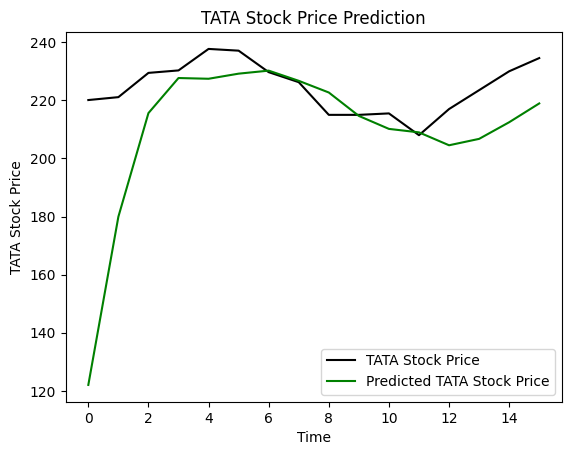

In [7]:
plt.plot(real_stock_price, color = 'black', label = 'TATA Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted TATA Stock Price')
plt.title('TATA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()


In [11]:
from statsforecast import StatsForecast


StatsForecast.plot(df=real_stock_price,forecasts_df=predicted_stock_price, engine='matplotlib')


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## 3.0

In [40]:
!pip install yfinance

In [54]:
# IMPORT THE LIBRARY
import yfinance as yf
import math
from datetime import datetime

# CREATE TICKER INSTANCE FOR AMAZON
#Initialize API
amzn = yf.Ticker("^BVSP")
#Make the end date the current day
end_date = datetime.now().strftime('%Y-%m-%d')
#Pull Stock Price History
amzn_hist = amzn.history(start='2010-01-01',end=end_date)
amzn_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04 00:00:00-02:00,68587.0,70081.0,68587.0,70045.0,1655400,0.0,0.0
2010-01-05 00:00:00-02:00,70046.0,70595.0,69928.0,70240.0,1984200,0.0,0.0
2010-01-06 00:00:00-02:00,70237.0,70937.0,70016.0,70729.0,2243600,0.0,0.0
2010-01-07 00:00:00-02:00,70723.0,70723.0,70045.0,70451.0,1555000,0.0,0.0
2010-01-08 00:00:00-02:00,70455.0,70766.0,70158.0,70263.0,1634400,0.0,0.0


In [55]:
#This code stores the closing prices of every stock we are looking at 
#into seperate arrays
amzn_close = amzn_hist['Close']
amzn_values = amzn_close.values
amzn_values = amzn_values.reshape(-1,1)
amzn_values

array([[ 70045.],
       [ 70240.],
       [ 70729.],
       ...,
       [127860.],
       [126590.],
       [126423.]])

In [56]:
#SCALING THE DATA
trainingScaler = MinMaxScaler(feature_range=(0,1))
#Transform the Values
amzn_values_scaled = trainingScaler.fit_transform(amzn_values)
print(len(amzn_values_scaled))

3606


In [57]:
training_split

5169

In [58]:
#CREATING TRAINING and TESTING DATASETS
training_split = math.floor(len(amzn_values_scaled) * 0.85) #3064+
#"X" values in batches of 50
training_amzn = amzn_values_scaled[0:training_split]
training_ind_amzn = []
training_dep_amzn = []

#Preparing Training Data
for i in range(50, len(training_amzn)):
  training_ind_amzn.append(training_amzn[i-50:i][0])
  training_dep_amzn.append(training_amzn[i][0])

training_ind_amzn, training_dep_amzn = np.array(training_ind_amzn), np.array(training_dep_amzn)
training_ind_amzn = np.reshape(training_ind_amzn, (training_ind_amzn.shape[0], training_ind_amzn.shape[1], 1))

In [59]:
# AMZN model
amzn_model = Sequential()
amzn_model.add(LSTM(100, return_sequences=True, input_shape=(training_ind_amzn.shape[1], 1)))
amzn_model.add(Dropout(0.2))
amzn_model.add(LSTM(100, return_sequences=True))
amzn_model.add(Dropout(0.2))
amzn_model.add(LSTM(100))
amzn_model.add(Dropout(0.2))
amzn_model.add(Dense(25))
amzn_model.add(Dense(1))
amzn_model.compile(optimizer='adam',loss='mean_squared_error')
amzn_model.fit(training_ind_amzn, training_dep_amzn, epochs = 200, batch_size = 32)

Epoch 1/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0804
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083
Epoch 13/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084
Epoch 14/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084
Epoch 15/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080
Epoc

In [60]:
#TESTING DATASET PREPARATION
# AMZN
testing_input_amzn = amzn_values[training_split:]
testing_input_amzn = trainingScaler.fit_transform(testing_input_amzn)
testing_amzn = []
for i in range(50, len(testing_input_amzn) + 50):
  testing_amzn.append(testing_input_amzn[i-50:i][0])
testing_amzn = np.array(testing_amzn)
testing_amzn = np.reshape(testing_amzn, (testing_amzn.shape[0], testing_amzn.shape[1], 1))
predict_amzn = amzn_model.predict(testing_amzn)
predict_amzn = trainingScaler.inverse_transform(predict_amzn)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


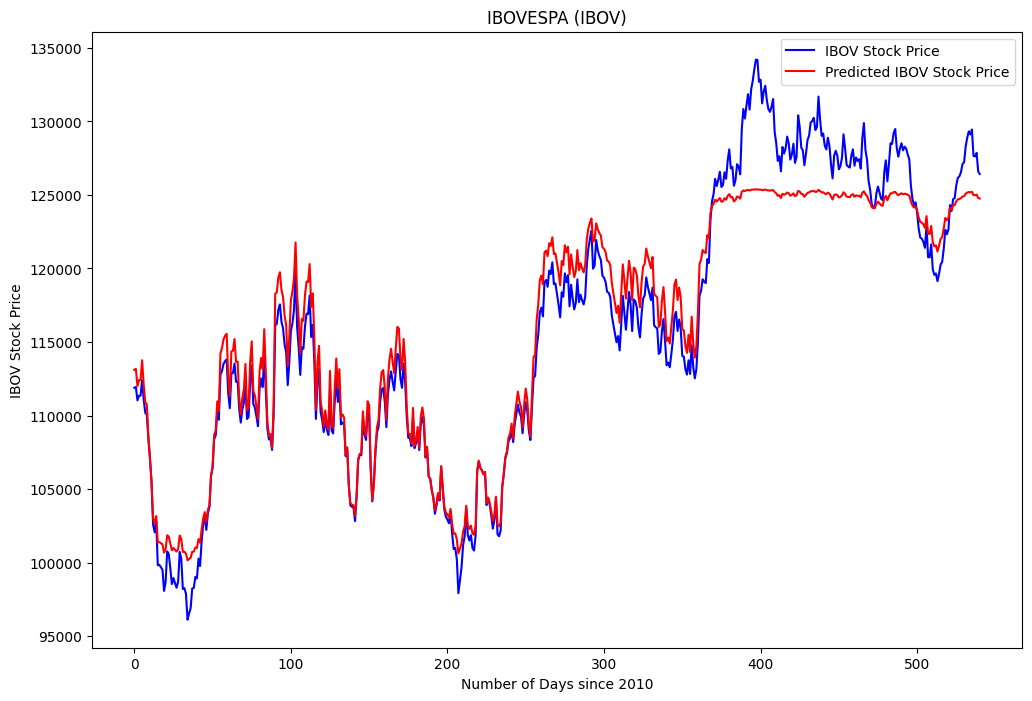

In [61]:
# AMZN
plt.plot(amzn_values[training_split:], color = 'blue', label = 'IBOV Stock Price')
plt.plot(predict_amzn, color = 'red', label = 'Predicted IBOV Stock Price')
plt.rcParams["figure.figsize"] = (12,8)
plt.title('IBOVESPA (IBOV)')
plt.xlabel('Number of Days since 2010')
plt.ylabel('IBOV Stock Price')
plt.legend()

plt.show()

In [73]:
print(metrics(amzn_values[training_split:], predict_amzn))

MPL: 875.7202301871534
DPS: 0.7801297532998661
DAES: 0.7801297532998661
R2: 0.9421543655850348
EVS: 0.9422064604088985
MAE: 1751.440460374307
MSE: 5134141.464647783
RMSE: 2265.8643967916046
MAPE: 1.46%
WMAPE: 1.51%
None


In [72]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_pinball_loss
from sklearn.metrics import d2_pinball_score
from sklearn.metrics import d2_absolute_error_score

def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()
    #return f"WMAPE: {res:.2%}"

def metrics(y_true, y_pred):
    #acc = accuracy_score(y_true, y_pred)
    mpl = mean_pinball_loss(y_true, y_pred)
    dps = d2_pinball_score(y_true, y_pred)
    daes = d2_absolute_error_score(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    wmape1 = wmape(y_true, y_pred)

    #print("ACC:",acc)
    print("MPL:",mpl)
    print("DPS:",dps)
    print("DAES:",daes)
    print("R2:",r2)
    print("EVS:",evs)
    print("MAE:",mae)
    print("MSE:",mse)
    print("RMSE:",rmse)
    print(f"MAPE: {mape:.2%}")
    print(f"WMAPE: {wmape1:.2%}")

In [10]:
print(metrics(amzn_values[training_split:], predict_amzn))

NameError: name 'predict_amzn' is not defined

## 3.1

In [107]:
%pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 40.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [88]:
#!pip uninstall -y fbprophet
#!pip uninstall -y pystan
#
# !pip install Cython
# !pip install fbprophet
# !pip install pystan==2.19.1.1 --no-binary :all:

  Using cached Cython-3.0.10-py2.py3-none-any.whl.metadata (3.2 kB)
Using cached Cython-3.0.10-py2.py3-none-any.whl (1.2 MB)
  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Using cached pystan-3.10.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached holidays-0.53-py3-none-any.whl.metadata (23 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.1.5-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.0 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl.metadata (1.6 kB)
INFO: pip is looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
  Using cached pystan-3.9.1-py3-none-any.whl

In [91]:
# Bibliotecas básicas de data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

# Para baixar os dados
import yfinance as yf


#Para aplicar o ARIMA:
from statsmodels.tsa.stattools import adfuller          #verificar dados estacionários
from statsmodels.tsa.stattools import acf, pacf         #correlação
from statsmodels.tsa.seasonal import seasonal_decompose #Decomposição sazonal usando médias móveis.
from statsmodels.tsa.arima.model import ARIMA           #algoritmo arima

# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Prophet
#from prophet import Prophet


In [63]:
import yfinance as yf

# Especifique o símbolo da Disney (DIS) e o intervalo de datas desejado
symbol = '^BVSP'
start_date = '2010-01-01'
end_date = '2024-07-01'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)

df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.head()

df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)

df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Close
0,2010-01-04,70045.0
1,2010-01-05,70240.0
2,2010-01-06,70729.0
3,2010-01-07,70451.0
4,2010-01-08,70263.0


In [13]:
close_data = df['Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [15]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

display(len(close_train))
display(len(close_test))

2870
718


In [16]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 10

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [17]:
from tensorflow.keras.metrics import MeanSquaredError

np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0312 - mean_squared_error: 0.0312
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2497e-04 - mean_squared_error: 6.2497e-04
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2246e-04 - mean_squared_error: 5.2246e-04
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2481e-04 - mean_squared_error: 8.2481e-04
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8044e-04 - mean_squared_error: 8.8044e-04
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8771e-04 - mean_squared_error: 7.8771e-04
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5395e-04 - mean_squared_error: 3.5395e-04
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8740e-04 - mean_squared_error: 3.8740e-04
Epoch 10/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8651e-04 - mean_s

In [18]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio", mse[0])

708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step - loss: 0.0013 - mean_squared_error: 0.0013
Erro Quadrático Médio 0.0012238041963428259


In [19]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f'MAPE: {mape:.4f}')

708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAPE: 3.1559


In [20]:
#O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.034982912919635865


In [21]:
print(metrics(test_actuals_inv, test_predictions_inv))

EVS: 0.8583251679026273
MAE: 3552.2379391772592
MSE: 19161354.07274313
RMSE: 4377.368395822213
MAPE: 3.16%
WMAPE: 3.11%
None


In [23]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições da IBOV",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 873us/step


In [24]:
df.head()

,Date,Close
0,2010-01-04,70045.0
1,2010-01-05,70240.0
2,2010-01-06,70729.0
3,2010-01-07,70451.0
4,2010-01-08,70263.0


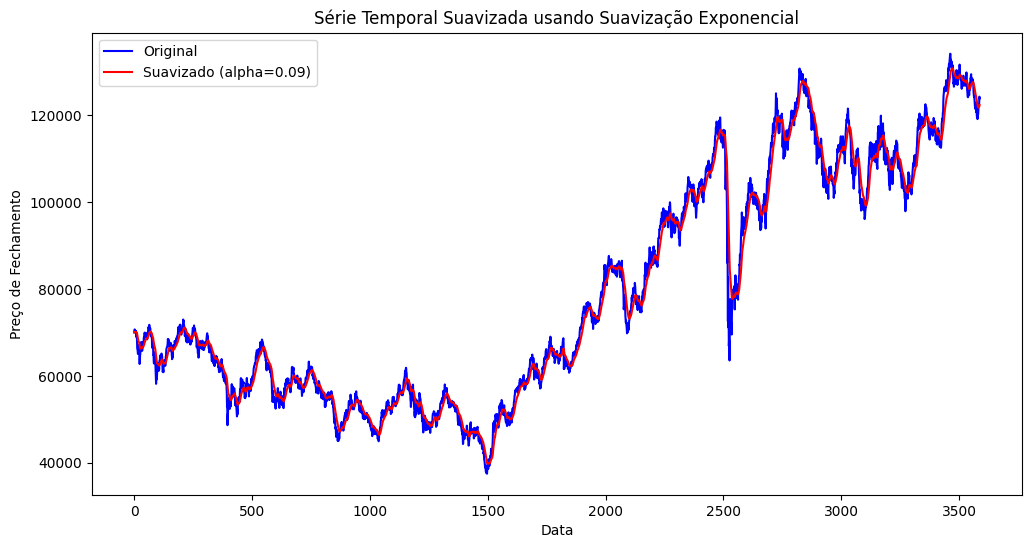

In [25]:
# Suazivando a série temporal
# Aplicando suavização exponencial
alpha = 0.09   # Fator de suavização
# O parâmetro alpha na suavização exponencial controla a taxa de decaimento dos pesos atribuídos às observações passadas.
# Determina o quão rapidamente o impacto das observações antigas diminui à medida que você avança no tempo.

df['Smoothed_Close'] = df['Close'].ewm(alpha=alpha, adjust=False).mean()

# Visualizando os resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Original', color='blue')
plt.plot(df.index, df['Smoothed_Close'], label=f'Suavizado (alpha={alpha})', color='red')
plt.title('Série Temporal Suavizada usando Suavização Exponencial')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

In [26]:
# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df['Smoothed_Close'] )
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')
    

ADF Statistic: -1.007501092325265
p-value: 0.7505186275553424
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -1.007501092325265
Valor-p: 0.7505186275553424
Valores Críticos:
   1%: -3.432178442676204
   5%: -2.8623479033634767
   10%: -2.5672000600324405


In [27]:
df.drop(columns=['Close'], inplace=True)
df.head()

,Date,Smoothed_Close
0,2010-01-04,70045.000000
1,2010-01-05,70062.550000
2,2010-01-06,70122.530500
3,2010-01-07,70152.092755
4,2010-01-08,70162.074407


In [28]:
close_data = df['Smoothed_Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [29]:
close_data

array([[0.3321939 ],
       [0.33238671],
       [0.33304571],
       ...,
       [0.90286349],
       [0.90515909],
       [0.90685158]])

In [30]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

2870
718


In [31]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 5

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)


In [32]:
np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[MeanSquaredError()])

num_epochs = 100
model.fit(train_generator, epochs=num_epochs, verbose=1)


Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0576 - mean_squared_error: 0.0576
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2497e-04 - mean_squared_error: 1.2497e-04
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0149e-04 - mean_squared_error: 1.0149e-04
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3792e-04 - mean_squared_error: 1.3792e-04
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5219e-04 - mean_squared_error: 1.5219e-04
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2449e-04 - mean_squared_error: 1.2449e-04
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3199e-04 - mean_squared_error: 1.3199e-04
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9273e-05 - mean_squared_error: 6.9273e-05
Epoch 9/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8749e-04 - mean_squared_error: 1.8749e-04
Epoch 10/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9

In [33]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f"MAPE: {mape:.2f}%")


713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step
MAPE: 0.65%


In [34]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio:", mse[0])


713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2.6978e-05 - mean_squared_error: 2.6978e-05
Erro Quadrático Médio: 2.4107413992169313e-05


In [35]:
# O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)


RMSE: 0.0049099301412718


In [74]:
print(metrics(test_actuals_inv, test_predictions_inv))

MPL: 365.6860001867987
DPS: 0.8908993540810777
DAES: 0.8908993540810777
R2: 0.9877970837782112
EVS: 0.9878081010194173
MAE: 731.3720003735974
MSE: 819257.7149683209
RMSE: 905.1285626740109
MAPE: 0.65%
WMAPE: 0.64%
None


In [38]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições IBOV",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step
